## Import libraries

In [ ]:
import tensorflow as tf #gan implementation
from tqdm import tqdm #progress bar
import numpy as np #load data
from IPython.display import clear_output #clear output
import random #random seed
import matplotlib.pyplot as plt #plotting
#function to scale data for display
def display_diagram(array):
  return (array + 1) / 2

## Load data and display

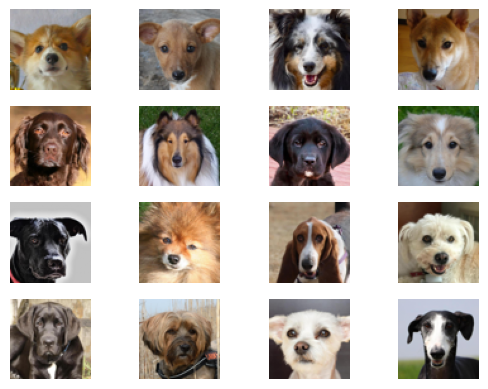

In [ ]:
data = np.load("dog_faces.npy") #load data
data = (data - 127.5) / 127.5 #normalize data
#create for loop to display images in a 4x4 grid
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(display_diagram(data[random.randint(0, data.shape[0])]))
    plt.axis('off')
noise_dim=128 #define noise dimension

## Generator Model

In [ ]:
generator = tf.keras.Sequential() #create empty model
#first block noise to 4x4x512
generator.add(tf.keras.layers.Dense(4*4*512, use_bias=False, input_shape=(noise_dim,)))
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU(0.2))
generator.add(tf.keras.layers.Reshape((4, 4, 512)))

#second block 4x4x512 to 8x8x256
generator.add(tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU(0.2))

#third block 8x8x256 to 16x16x128
generator.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU(0.2))

#fourth block 16x16x128 to 32x32x64
generator.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU())

#final block 32x32x64 to 64x64x3
generator.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
generator.summary() #print summary of model

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_47 (Dense)            (None, 8192)              1048576   
                                                                 
 batch_normalization_101 (B  (None, 8192)              32768     
 atchNormalization)                                              
                                                                 
 leaky_re_lu_161 (LeakyReLU  (None, 8192)              0         
 )                                                               
                                                                 
 reshape_27 (Reshape)        (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_104 (Conv  (None, 8, 8, 256)         3276800   
 2DTranspose)                                                    
                                                     

## Generate Samples

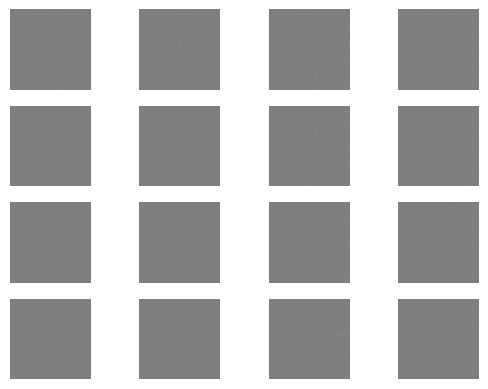

In [ ]:
#generate images using gaussian distribution
generated_samples = generator(tf.random.normal(shape=(16, 128), mean=0.0, stddev=1.0), training=False)
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(display_diagram(generated_samples[i]))
    plt.axis('off')

## Discriminator Model

In [ ]:
discriminator = tf.keras.Sequential() #create empty model
#first block 64x64x3 to 32x32x64
discriminator.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(64, 64, 3)))
discriminator.add(tf.keras.layers.LeakyReLU(0.2))
discriminator.add(tf.keras.layers.Dropout(0.3))

#second block 32x32x64 to 16x16x128
discriminator.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(tf.keras.layers.LeakyReLU(0.2))
discriminator.add(tf.keras.layers.Dropout(0.3))

#third block 16x16x128 to 8x8x256
discriminator.add(tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(tf.keras.layers.LeakyReLU(0.2))
discriminator.add(tf.keras.layers.Dropout(0.3))

#fina block 8x8x256 to decision
discriminator.add(tf.keras.layers.Flatten())
discriminator.add(tf.keras.layers.Dense(1, activation='sigmoid'))
discriminator.summary()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu_165 (LeakyReLU  (None, 32, 32, 64)        0         
 )                                                               
                                                                 
 dropout_60 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_61 (Conv2D)          (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_166 (LeakyReLU  (None, 16, 16, 128)       0         
 )                                                               
                                                                 
 dropout_61 (Dropout)        (None, 16, 16, 128)     

## Check Generated Images

In [ ]:
#check discriminator output on generated images
discriminator(generated_samples, training=False)

<tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[0.5001638 ],
       [0.5001561 ],
       [0.49989912],
       [0.5001122 ],
       [0.5000619 ],
       [0.50008845],
       [0.5001353 ],
       [0.5002225 ],
       [0.5002227 ],
       [0.5000354 ],
       [0.50021034],
       [0.5002063 ],
       [0.5002059 ],
       [0.50017   ],
       [0.50005466],
       [0.5002808 ]], dtype=float32)>

## Define Losses and Optimizers

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False) #define loss function

#discriminator loss function
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return (real_loss + fake_loss) / 2

#generator loss function
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#optimizers
generator_optimizer = tf.keras.optimizers.Adam(lr=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=2e-4, beta_1=0.5)

## Define Training Step Function

In [ ]:
@tf.function #tf.function decorator
def train_step(images):
    noise = tf.random.normal(shape=(BATCH_SIZE, noise_dim), mean=0.0, stddev=1.0) #generate noise

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True) #generate images

        real_output = discriminator(images, training=True) #discriminator output on real images
        fake_output = discriminator(generated_images, training=True) #discriminator output on generated images

        gen_loss = generator_loss(fake_output) #calculate generator loss
        disc_loss = discriminator_loss(real_output, fake_output) #calculate discriminator loss

    #calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) X
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #apply gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    #return losses for storing
    return gen_loss, disc_loss

## Train Model

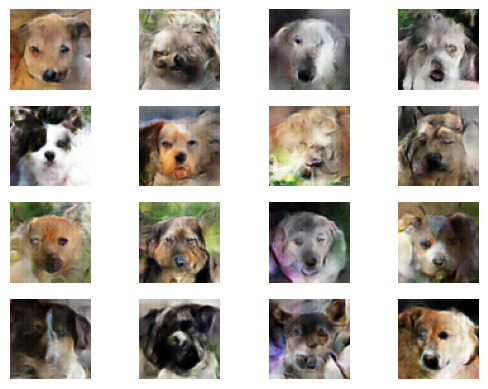

In [ ]:
BATCH_SIZE = 64
#shuffle and batch data
train_dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(data.shape[0]).batch(BATCH_SIZE)
#create lists to store losses
gen_losses = []
disc_losses = []
EPOCHS = 500
seed = tf.random.normal([16, noise_dim]) #create seed for generating images
for epoch in range(EPOCHS):
    #train model on dataset
    for image_batch in tqdm(train_dataset, desc=f'Epoch {epoch+1}/{EPOCHS}'):
        gen_loss, disc_loss = train_step(image_batch)
    print(f'Gen loss - {gen_loss}, Disc loss - {disc_loss}')
    #store losses
    gen_losses.append(gen_loss)
    disc_losses.append(disc_loss)
    #every 10 epochs, generate images and save them, then clear output
    if (epoch+1) % 10 == 0:
      generated_samples = generator(seed, training=False)
      for i in range(16):
          plt.subplot(4, 4, i+1)
          plt.imshow(display_diagram(generated_samples[i]))
          plt.axis('off')
      plt.savefig(f'images/GAN_{epoch+1}.png')
      clear_output(wait=True)

## Display Image

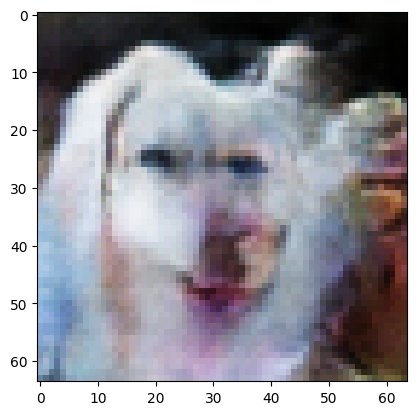

In [231]:
#after training, generate lone image
plt.imshow(display_diagram(generator(tf.random.normal(shape=(1, 128), mean=0.0, stddev=1.0))[0]))

## Save Models

In [ ]:
#save models
generator.save("content/generator_dogs.h5")
discriminator.save("discriminator_dogs.h5")

## Graph Losses

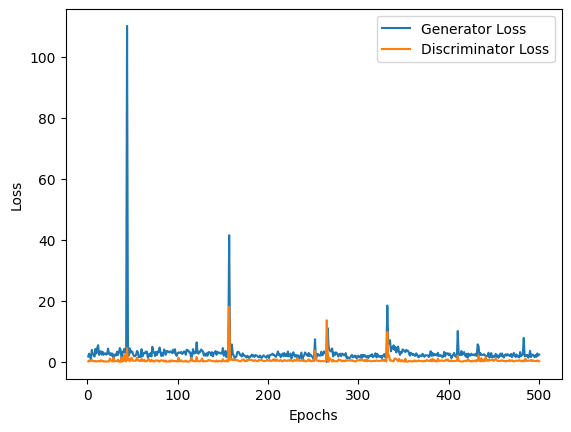

In [233]:
#graph losses
plt.plot(range(1, EPOCHS+1), gen_losses, label='Generator Loss') #graph generator loss
plt.plot(range(1, EPOCHS+1), disc_losses, label='Discriminator Loss') #graph discriminator loss
#label graph
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()